# ProductNet: Categorize products using image(s) and text descriptors
## Jen Sheng Wong and Kartik Nanda (Cohort 14)
Based on following paper: https://arxiv.org/pdf/1904.09037.pdf

## Problem Statement:
Relates primarily to products on retail/marketplace sites such as Amazon. The problem deals with 3 main aspects:
* Trying to categorize products. Number of categories ~5000 (using the Google taxonomy: https://github.com/fellowship/platform-demos3/blob/master/ProductNet/taxonomy-with-ids.en-US.xls)
* Product has images (1 or more)
* Product has text - title, description, keywords

Possible end-problems to solve: 
a) Find the category, given product images and user provided text description. 
b) Find mis-categorized products

## Dataset: 
Products for sale on Amazon; product details from 1996 through 2014, by Prof. McAuley at UCSD
Citations:
* R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016
* J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015

## Dataset Storage:
* Used Google storage bucket located at gs://platform-ai-research/datasets/ProductNet/
* Also used Jen Sheng's Google Drive for intermediate files, images etc

In [1]:
!pip install fastai
!pip install pyarrow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import gc
from tqdm import tqdm

from PIL import Image

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

     |████████████████████████████████| 48.5MB 41.8MB/s 


## Cleaning the Dataset
Our initial challenges were dealing with the dataset. 
* Its 9.5 million entries. Many of them we can not easily use (example Books, Videos etc). Initial steps: dealing with the size and the initial cleaning - these are captured in a separate script: https://github.com/fellowship/platform-demos3/blob/master/ProductNet/workbook_1.ipynb
* Clean up the category, names - reduce the number of categories we are dealing with. In the beginning only 40 categories. This is probably not ideal because the categories are very high level, and it might actually result in worse numbers.
* Data distribution across categories is not balanced. Decided to sub-sample, which has 2 benefits: a) Reduces the size of the dataset to something more manageable (from 6.5 million at the and of step 1); b) provides a balanced distribution between the various categories
* Download the image files using the urls in the dataset. These were stored in Google Drive. Missing instances were removed from the dataset.

In [2]:
# Set the file name - this is the output file from step1 (workbook_1)
file_name = 'metadata_clean_0513'

# set local to False if running on Colab
local = False      # this needs to be automated (how?)

# Reading in the datafile
exists = os.path.isfile(file_name)
if (not exists):
    if (not local):
        # Login to access the GS bucket
        from google.colab import auth
        auth.authenticate_user()

        # Copy the datafile to the Colab local dir
        gs_path = 'platform-ai-research/datasets/ProductNet/'
        remote_file = gs_path + file_name
        !gsutil cp gs://{remote_file} {file_name}
                
    else: 
        print('File Does Not Exist')
        sys.exit()

# Read in the file
df = pd.read_feather(file_name)

# # Drop records with missing labels
# df.dropna(subset=['label'], inplace=True)

Copying gs://platform-ai-research/datasets/ProductNet/metadata_clean_0513...
|
Operation completed over 1 objects/3.1 GiB.                                      


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5607160 entries, 0 to 5607159
Data columns (total 7 columns):
index          int64
asin           object
categories     object
description    object
imUrl          object
title          object
label          object
dtypes: int64(1), object(6)
memory usage: 299.5+ MB


In [4]:
s = df.categories.str.split(',',-1).str[-1]
len(s.unique())

12678

In [5]:
# See the distribution of the categories
xx = np.array([])
yy = np.array([])
for l in df.label.unique():
    i = len(df[df.label == l])
    print('label = ', l, ' Number of instances = ', str(i))
    xx = np.append(xx,[l])
    yy = np.append(yy,[i])

label =  Clothing  Number of instances =  1435827
label =  Sports & Outdoors  Number of instances =  529408
label =  Toys & Games  Number of instances =  334199
label =  Musical Instruments  Number of instances =  67513
label =  Tools & Home Improvement  Number of instances =  268464
label =  Home & Kitchen  Number of instances =  436927
label =  Health & Personal Care  Number of instances =  262304
label =  Cell Phones & Accessories  Number of instances =  346691
label =  Office Products  Number of instances =  130698
label =  Electronics  Number of instances =  494401
label =  Office & School Supplies  Number of instances =  3316
label =  Baby  Number of instances =  71317
label =  Beauty  Number of instances =  258561
label =  Automotive  Number of instances =  330448
label =  Arts  Number of instances =  115709
label =  Computers  Number of instances =  4450
label =  All Electronics  Number of instances =  7571
label =  Pet Supplies  Number of instances =  110535
label =  Grocery &

In [0]:
xsorted = []

ysorted = sorted(yy, reverse=True)
y_idx = np.argsort(yy)[::-1]

for idx in y_idx:
    xsorted.append(xx[idx])

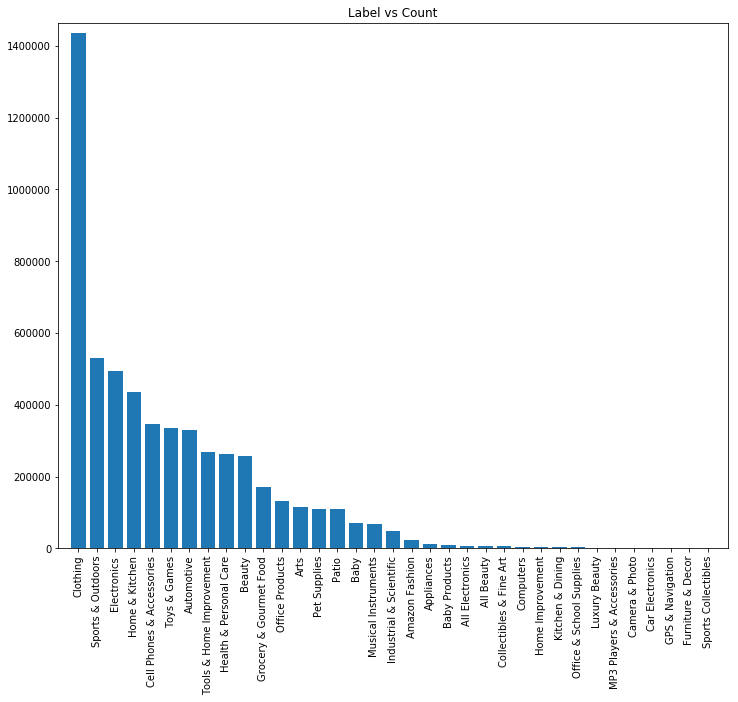

In [7]:
ys = ysorted # [1:] # to remove 'Clothing' as a label
xs = xsorted # [1:] # to remove 'Clothing' as a label

# Plot the distribution
plt.subplots(figsize=(12,10))
plt.bar(range(1,len(ys)+1), ys)
labels = xs
plt.xticks(range(1,len(ys)+1), labels, rotation='vertical')
plt.margins(0.02)
plt.title('Label vs Count')
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

In [0]:
# Calculate weights for categories
# Need an even distributed dataset - all categories should have approx. same number of instances
def calc_weight(label):
    wt = 1/int(yy[np.where(xx==label)])
    return wt

In [0]:
df['weight'] = df.label.apply(calc_weight)

In [10]:
# Sum of all the weights should be equal to the number of categories
sum(df.weight)

34.99999999981303

In [0]:
# The distribution is uneven, assign weights and subsample unevenly
df2 = df.sample(n=10000, weights='weight', random_state=2)

In [12]:
# See the distribution of the categories
xx = np.array([])
yy = np.array([])
for l in df2.label.unique():
    i = len(df2[df2.label == l])
    print('label = ', l, ' Number of instances = ', str(i))
    xx = np.append(xx,[l])
    yy = np.append(yy,[i])

label =  Home & Kitchen  Number of instances =  328
label =  Sports & Outdoors  Number of instances =  317
label =  Toys & Games  Number of instances =  335
label =  Arts  Number of instances =  333
label =  Musical Instruments  Number of instances =  307
label =  Camera & Photo  Number of instances =  227
label =  Office Products  Number of instances =  317
label =  Kitchen & Dining  Number of instances =  306
label =  Pet Supplies  Number of instances =  323
label =  Cell Phones & Accessories  Number of instances =  297
label =  Health & Personal Care  Number of instances =  295
label =  MP3 Players & Accessories  Number of instances =  286
label =  Patio  Number of instances =  286
label =  Collectibles & Fine Art  Number of instances =  311
label =  Grocery & Gourmet Food  Number of instances =  304
label =  Computers  Number of instances =  285
label =  Amazon Fashion  Number of instances =  286
label =  Luxury Beauty  Number of instances =  263
label =  Car Electronics  Number of

In [0]:
xsorted = []

ysorted = sorted(yy, reverse=True)
y_idx = np.argsort(yy)[::-1]

for idx in y_idx:
    xsorted.append(xx[idx])

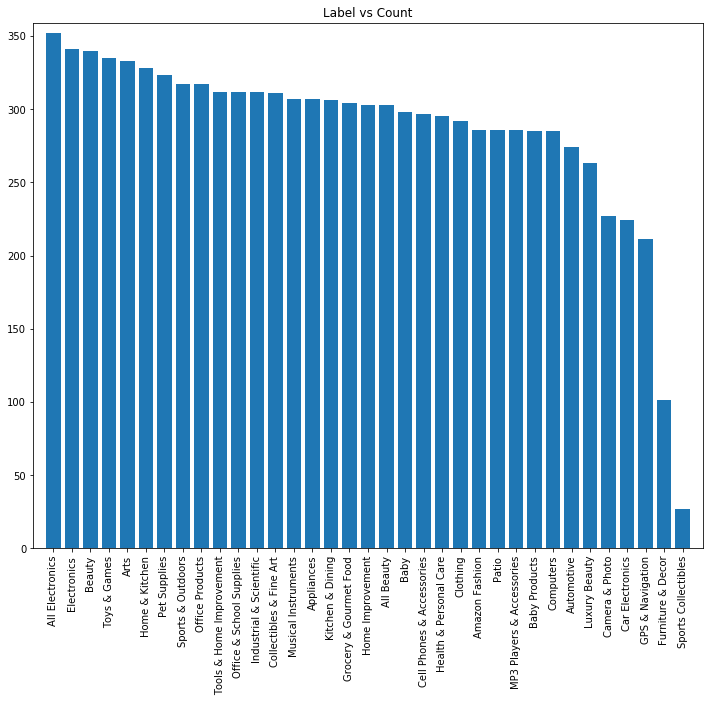

In [14]:
ys = ysorted # [1:] # to remove 'Clothing' as a label
xs = xsorted # [1:] # to remove 'Clothing' as a label

# Plot the distribution
plt.subplots(figsize=(12,10))
plt.bar(range(1,len(ys)+1), ys)
labels = xs
plt.xticks(range(1,len(ys)+1), labels, rotation='vertical')
plt.margins(0.02)
plt.title('Label vs Count')
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

In [0]:
# Next step is to download the images
if (not os.path.exists('./images/')):
    !mkdir 'images'

In [19]:
gs_path = 'platform-ai-research/datasets/ProductNet/'
file_name = 'images'

remote_file = gs_path + file_name
!gsutil cp -r gs://{remote_file} {file_name} 

Copying gs://platform-ai-research/datasets/ProductNet/images/0439652154.jpg...
Copying gs://platform-ai-research/datasets/ProductNet/images/0545140587.jpg...
Copying gs://platform-ai-research/datasets/ProductNet/images/0985308133.jpg...
Copying gs://platform-ai-research/datasets/ProductNet/images/1403774013.jpg...
\ [4 files][ 76.3 KiB/ 76.3 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://platform-ai-research/datasets/ProductNet/images/1427613648.jpg...
Copying gs://platform-ai-research/datasets/ProductNet/images/1591270952.jpg...
Copying gs://platform-ai-research/datasets/ProductNet/images/1600851002.jpg...
Copying gs://platform-ai-research/datasets/ProductNet/images/161992238X.jpg...
Copying gs://platform-ai-research/d

In [18]:
imUrls = df2.imUrl.tolist()
asins = df2.asin.tolist()

# %%time
for url_id in zip(imUrls, asins):
    url = url_id[0] # url of image
    asin = url_id[1] # asin of image
    filename = './images/' + asin + '.jpg'
  
    # also check if file exists. If it does, do not reload it!
    if (not os.path.isfile(filename)):
        try:
            r = requests.get(url, allow_redirects=True)
            open(filename, 'wb').write(r.content)
            
        except Exception as e:
            df2 = df2[df2.asin != asin]           # if missing, remove from dataset
            with open("./missing.txt", "a") as f:
                f.write(asin+'\n')

KeyboardInterrupt: ignored

In [0]:
from tqdm import tqdm
from PIL import Image

for url_id in tqdm(zip(imUrls, asins)):
    url = url_id[0] # url of image
    asin = url_id[1] # asin of image
    filename = './images/' + asin + '.jpg'
    
    try:
        img = Image.open(filename)
    except Exception as e:
        df2 = df2[df2.asin != asin]           # if missing, remove from dataset
        with open("./missing_imgs.txt", "a") as f:
            f.write(asin+'\n')


In [0]:
# gs_path = 'platform-ai-research/datasets/ProductNet/'
# file_name = 'images'

# remote_file = gs_path + file_name
# !gsutil cp -r {file_name} gs://{remote_file} 

In [0]:
# df3 = df2[['asin', 'label']].copy()

df3 = df2[['asin', 'categories']].copy()

In [0]:
df3.head()

In [0]:
tfms = get_transforms(max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
# src = ImageDataBunch.from_df('./', 
#                              df3, 
#                              folder='images', 
#                              suffix='.jpg', 
#                              ds_tfms=tfms, 
#                              size=224, 
#                              bs=128).normalize(imagenet_stats)

# src = (ImageList.from_csv(PATH, 'train_v2.csv', folder='images', suffix='.jpg')
#        .split_by_rand_pct(0.2)
#        .label_from_df(label_delim=' '))

src = (ImageList.from_df(path='./', 
                         df=df3, 
                         folder='images', 
                         suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=','))

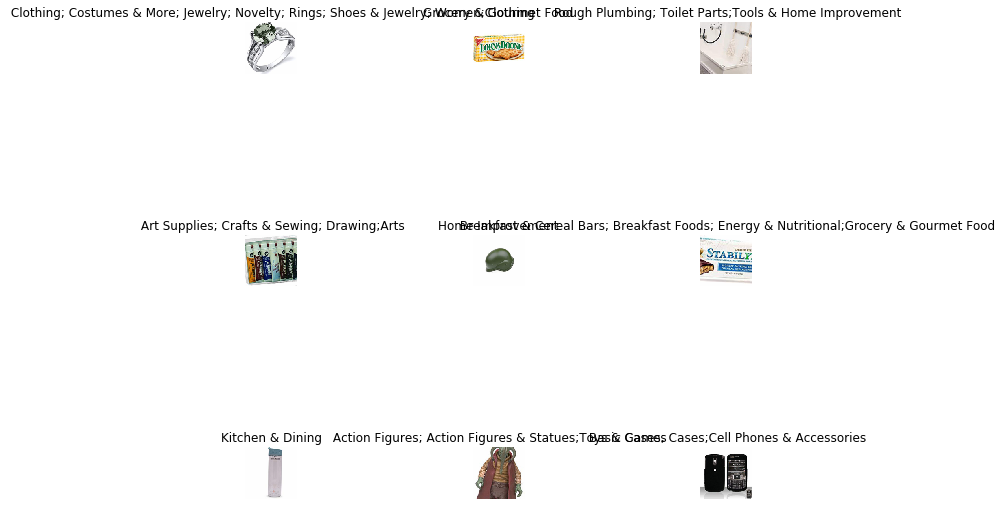

In [140]:
# src.show_batch(rows=3, figsize=(8,6))

data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

data.show_batch(rows=3, figsize=(12,9))

In [141]:
gc.collect()

# print(src.classes)
# len(src.classes),src.c

print(data.classes)

len(data.classes), data.c

[' 12V', ' 3D Printers', ' 3D Printing Materials', ' 6V', ' AC Adapters', ' ASICS', ' Abrasive & Finishing Products', ' Abrasive Brushes', ' Abrasive Wheels & Discs', ' Absorbent Pads', ' Accent & Off Road Lighting', ' Accessories', ' Accessories & Supplies', ' Accessory Kits', ' Acid Reflux Pillows', ' Acids & Peels', ' Acoustic & Classical Guitar Bags & Cases', ' Acoustic & Classical Guitar Parts', ' Acoustic Guitar Strings', ' Acoustic Guitars', ' Acoustic Violins', ' Acoustic-Electric Guitars', ' Acoustical Treatments', ' Action & Toy Figures', ' Action Figures', ' Action Figures & Statues', ' Action Sports', ' Active', ' Active Hoodies', ' Active Leggings', ' Active Pants', ' Active Shirts & Tees', ' Active Shorts', ' Active Skirts', ' Active Sweatshirts', ' Active Top & Bottom Sets', ' Active Vests', ' Activity', ' Activity Centers & Entertainers', ' Activity Tables', ' Activity Trees', ' Acupuncture', ' Adapters', ' Adapters & Multi-Outlets', ' Additive Manufacturing Products', 

(3335, 3335)

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import linear_kernel
import numpy as np

def get_cos_sim(xtrain_embeddings):
    scl = StandardScaler()
    xtrain_embeddings = np.array(xtrain_embeddings)
    xtrain_embeddings = scl.fit_transform(xtrain_embeddings)

    cos_sim = linear_kernel(xtrain_embeddings, xtrain_embeddings)
    
    return cos_sim, scl

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from __future__ import absolute_import, division, print_function
import tensorflow_hub as hub

hub_embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")

In [0]:
def get_use_matrix(s):
    embeddings = hub_embed(s)

    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        xtrain_embeddings = session.run(embeddings)
        
    return xtrain_embeddings

In [0]:
s = df2.categories.values

In [0]:
%%time
classes_embeddings = get_use_matrix(s)

In [0]:
gs_path = 'platform-ai-research/datasets/ProductNet/'
file_name = 'taxonomy-with-ids.en-US.xls'

remote_file = gs_path + file_name
!gsutil cp -r {file_name} gs://{remote_file} 

In [0]:
taxo = pd.read_excel('taxonomy-with-ids.en-US.xls')

taxo = taxo.fillna('')

# get columns
level_2 = taxo.iloc[:, 2].unique()

In [0]:
taxo_embeddings = get_use_matrix(level_2)

In [0]:
cos_sim = linear_kernel(classes_embeddings, taxo_embeddings)

In [0]:
top_idx = []

for cs in cos_sim:
    top_idx.append(np.argmax(cs))

In [0]:
for t in zip(s, top_idx):
  print(t[0], '......', level_2[t[1]])

In [0]:
# learn = cnn_learner(src, models.resnet50, metrics=error_rate)
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

learn = cnn_learner(data, models.resnet50, metrics=[acc_02, f_score])

In [143]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.315213,0.011232,0.999174,0.000358,00:52
1,0.030697,0.005300,0.999161,0.032278,00:53
2,0.007851,0.004889,0.999166,0.046552,00:51
3,0.005782,0.004831,0.999169,0.046701,00:52


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
losses,idxs = interp.top_losses()

In [0]:
# interp.plot_top_losses(9, figsize=(15,11))

In [0]:
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
learn.unfreeze()

In [145]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.005637,0.004638,0.999159,0.078943,00:55


In [0]:
learn.save('stage-1-50-multi')

In [136]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


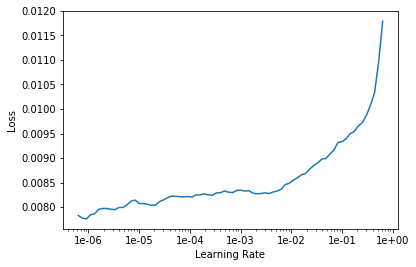

In [137]:
gc.collect()
learn.recorder.plot()

In [42]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.949426,3.014836,0.823202,01:09
1,2.811813,2.970970,0.811044,01:09
2,2.722167,2.964615,0.830294,01:09
3,2.627068,2.935141,0.797366,01:07
4,2.468180,2.957638,0.803445,01:08
5,2.288225,2.970216,0.799392,01:09
6,2.050023,2.906169,0.778622,01:08
7,1.785010,2.934784,0.776089,01:11
8,1.560538,2.950842,0.777102,01:11
9,1.431531,2.966960,0.778116,01:09


In [82]:
train_len = len(src.train_ds)
valid_len = len(src.valid_ds)

train_len, valid_len

(7897, 1974)

In [0]:
train = src.train_ds.x.items[:]
valid = src.valid_ds.x.items[:]

train_sorter = []
valid_sorter = []

for s in train:
    train_sorter.append(str(s).strip('.jpg').strip('/images'))
    
for s in valid:
    valid_sorter.append(str(s).strip('.jpg').strip('/images'))    

In [0]:
sorter = train_sorter + valid_sorter

sorterIndex = dict(zip(sorter,range(len(sorter))))

df2['rank'] = df2['asin'].map(sorterIndex)

In [0]:
df2 = df2.sort_values('rank')

df2.tail()

# Text features

In [69]:
import nltk
import numpy as np
from tqdm import tqdm

nltk.download('stopwords')
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [70]:
gs_path = 'platform-ai-research/datasets/ProductNet/'
file_name = 'crawl-300d-2M.vec'
remote_file = gs_path + file_name
!gsutil cp gs://{remote_file} {file_name}

Copying gs://platform-ai-research/datasets/ProductNet/crawl-300d-2M.vec...
- [1 files][  4.2 GiB/  4.2 GiB]  100.5 MiB/s                                   
Operation completed over 1 objects/4.2 GiB.                                      


In [71]:
embeddings_index = {}
f = open('crawl-300d-2M.vec')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2000001it [02:14, 14907.98it/s]

Found 2000000 word vectors.


In [0]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [73]:
df2.head()

,index,asin,categories,description,imUrl,title,label,weight,rank
74716,85967,B0000AQHW3,"Sports & Outdoors, Exercise & Fitness, Strengt...",Standard flat plates in black finish. Availabl...,http://ecx.images-amazon.com/images/I/31LwFOni...,Champion Barbell 10-Pounds Standard Flat Plate,Sports & Outdoors,0.000002,0
2533592,2850172,B004RJTET8,"Toys & Games, Novelty & Gag Toys, Toy Balls",100pc High Quality INTEX play balls\nvery smoo...,http://ecx.images-amazon.com/images/I/51-8XfLf...,100 Plastic Balls,Toys & Games,0.000003,1
1798346,2031116,B0037IOXMS,"Musical Instruments, Instrument Accessories, G...",Woodies Guitar Hanger is a cleverly designed w...,http://ecx.images-amazon.com/images/I/51XtPwLz...,Woodies Hanger: The Ultimate Guitar Hanger - G...,Musical Instruments,0.000015,2
1354502,1534251,B001VS4P56,Camera & Photo,LASERSHIELD PRO INSTANT SECURITY NEXT985MCW Pe...,http://ecx.images-amazon.com/images/I/31T0SZts...,Visonic Next K9-85 MCW Wireless Pet Immune Mot...,Camera & Photo,0.002165,3
800558,875529,B000X2TVMS,Camera & Photo,InDash Custom Dash mounts from PanaVise are ve...,http://ecx.images-amazon.com/images/I/41MRPA56...,Panavise InDash Custom Mount 751371804 for 200...,Camera & Photo,0.002165,4


In [85]:
xtrain = df2.categories.values[:train_len]
xvalid = df2.categories.values[train_len:]

xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|██████████| 1974/1974 [00:00<00:00, 5904.26it/s]


In [0]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

In [87]:
xtrain_glove.shape, xvalid_glove.shape

((7897, 300), (1974, 300))

In [0]:
learn = cnn_learner(src, models.resnet50, metrics=error_rate)

learn.load('stage-1-50')

m = learn.model.eval()

# Concatenate word embeddings with activations of last layer 

In [0]:
# get the output of penultimate layer
from fastai.callbacks.hooks import *

# Function to forward pass the image and fetching the penultimate layer using the fastai hooks
def get_activations(m, x):
    "Return activations of the penultimate layer after forward pass of an image through CNN"
    xb,_ = src.one_item(x)
    # xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    with hook_output(m[1][4]) as hook_a: 
        preds = m(xb)
    acts  = hook_a.stored[0].cpu()
    return acts

In [111]:
gc.collect()

2470

In [0]:
final_layer = []

for i in range(train_len):
    x = src.train_ds[i][0]
    v = get_activations(m, x).numpy()
    
    # print(v.shape), print(xtrain_glove[i].shape)
    
    conc = np.concatenate([v, xtrain_glove[i]])
    
    final_layer.append(conc)    

In [109]:
print(len(final_layer))

for i in range(valid_len):
    x = src.valid_ds[i][0]
    v = get_activations(m, x).numpy()
    
    # print(v.shape), print(xtrain_glove[i].shape)
    
    conc = np.concatenate([v, xvalid_glove[i]])
    
    final_layer.append(conc)

7897


In [110]:
final_layer = np.array(final_layer)

final_layer.shape

(9871, 812)